# MA 755 A2 Classification on College Score Board Data


Data Source:  https://collegescorecard.ed.gov/data  

Group Members: Stacy Li, Michelle Zhao

In the first assignment, we use regression to help us predict post-graduation earnings and understand what factors may be predictive of earnings. In assignment two, we are going to use classification models to predict if the median earnings of a school's students exceed the median level across all institutions.

## 1. Data Preparation

First, we import all necessary packages.

In [45]:
import pickle
from sklearn.linear_model    import SGDClassifier,LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import sklearn.pipeline as sk_pl
import sklearn.preprocessing as sk_pp
import sklearn.svm as sk_sv

   ### 1.1 Import the data

The data we are using here is the clean data output from the transformation pipeline in the assignment one. We saved the training data, training label, testing data and testing label into separate pickle files so that we can easily access to them later. 

In [ ]:
college = pickle.load(open("college.p","rb"))
college_label = pickle.load(open("college_label.p","rb"))
college_test = pickle.load(open("college_test.p","rb"))
college_test_label = pickle.load(open("college_test_label.p","rb"))

### 1.2 Encode earnings into categorical variable

After importing data, we notice that the training/testing labels we use in last assignment are continuous values. However, in this case, our objective is to study if the median earnings of a school if above the overall median level of this data set. The answer would be either Yes or No. So We need to encode the training/testing data into binary labels.  

In [5]:
quantiles = college_label.quantile(q=0.5)

In [165]:
quantiles #median earnings

30600.0

Then we write a function to help us perform this transformation.

In [7]:
def median_code(data):
    if data < quantiles:
        return 0
    else:
        return 1

In [8]:
college_label = college_label.map(median_code)

In [9]:
college_test_label = college_test_label.map(median_code)

The resulting labels only have two values: 0 or 1. 0 stands for below the median level while 1 stand for above the median level.

Now, we have all the data ready for training classification models. The following part will illustrate how to train a logistic classfier and random forest classifier.

## 2. Logistic Classifier

There are two algorithms to perform logistic classification in the Scikit-Learn package: *LogisticRegression* and *SGDClassifier(loss = log)*. The difference between this classifier is that *LogisticRegression* processes input in batch while *SGDClassifier(loss = log)* process input one instance each time. So *SGDClassifier(loss = log)* is natually a better approach to handling large dataset or online learning. In this case, we choose to use *LogisticRegression* since the dataset is relatively small.

### 2.1 Train a logistic regression model

In [64]:
log_clf = LogisticRegression(solver = 'liblinear',
                            random_state = 42) #set seed to make the result can be reproduced

In [65]:
train_fit = log_clf.fit(college,college_label)

### 2.2 Performance Measures

Then we use cross-validation to measure the performance of the model. In this case, we splited the data set into three parts of equal size. The model is trained on two of three datasets and evaluate on the unused dataset.

In [66]:
#Cross-validation
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
for train_index, test_index in skfolds.split(college,college_label):
    clone_clf = clone(log_clf)
    X_train_folds = college[train_index]
    y_train_folds = (np.array(college_label)[train_index])
    X_test_fold = college[test_index]
    y_test_fold = np.array(college_label)[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.782907049283
0.842072409488
0.73720349563


The result shows that the accuracies on three testing dataset are 78%, 84% and 74% repectively. The performance of the model is ok but is not satisfying enough.

Then we used the confusion matrix to compare the actual results with the predicted results generated from the model.The diagnoal from top left to down right show the number instances that are correctly classfied. 

In [68]:
#confusion_matrix
y_train_pred = cross_val_predict(clone_clf, college, college_label)
confusion_matrix(college_label,y_train_pred)

array([[2027,  376],
       [ 646, 1758]])

We can tell that most instances are correctly classfied by the *LogisticRegression*, but there are still some cases are incorretly classfied, especially more actual NO are predicted to Yes.

Finally, we calculated the F1 score of the model to represent its overall performance.

In [69]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(classification_report(college_label, y_train_pred))

             precision    recall  f1-score   support

          0       0.76      0.84      0.80      2403
          1       0.82      0.73      0.77      2404

avg / total       0.79      0.79      0.79      4807



After evaluating the performance of the model, we also want to see how changes in the thresholds would influence the precision and recall we get so that we can select an optimal threshold.

In [71]:
y_scores = cross_val_predict(clone_clf,college,college_label,cv=3, method = 'predict_proba' )

In [72]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(college_label,y_scores[:,1])

In [73]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label = 'Precision')
    plt.plot(thresholds,recalls[:-1],"g-",label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = 'upper left')
    plt.ylim([0,1])

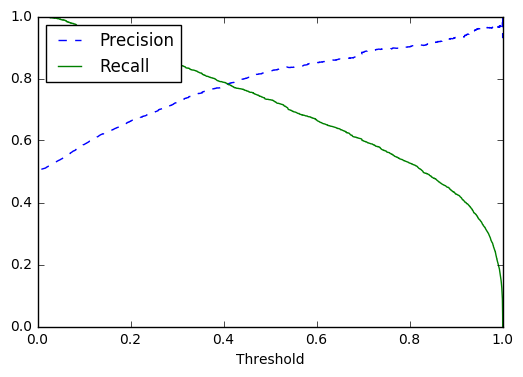

In [178]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In this case, we don't have any preference for Precision or Recall, so it seems that lowering the threshold a litte bit to around 0.4 would strike a balance between Precision and Recall.

Likewise, we ploted Precision against Recall in the following plot.

(0, 1)

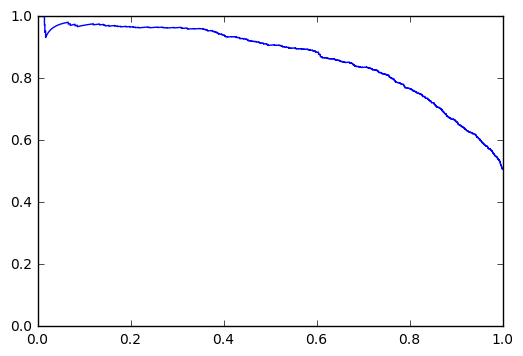

In [74]:
plt.plot(recalls[:-1],precisions[:-1]);
plt.ylim([0,1])
plt.ylim([0,1])

Another way to evaluate model performance is ROC Curve. It plots the False Positive Rate against the True Positive Rate.

### 2.3 The ROC Curve

In [75]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr,thresholds = roc_curve(college_label,y_scores[:,1])

In [76]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

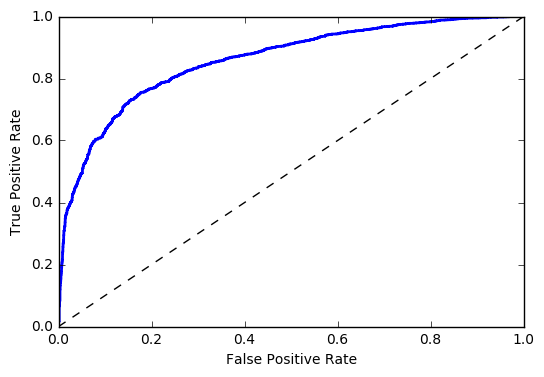

In [182]:
plot_roc_curve(fpr,tpr);

In [183]:
roc_auc_score(college_label,y_scores[:,1])

0.85897896625335912

The area under ROC Curve is 0.86. The higher the area under the curve, the better the performance of the model. It should also be noted that we should prefer Precision Recall Curve to evaluate the model whenever there are fewer positive cases than negative cases or we care more about false positive than false negative.

## 3. Random Forest Classifier

### 3.1 Train a random forest model

In [77]:
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(college, college_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

### 3.2 Performance Measures

#### Measuring accuracy on training set

In [114]:
pred_rf = rf_clf.predict(college)
rf_clf.score(college, college_label)

0.99251092157270648

In [115]:
print(confusion_matrix(college_label,pred_rf))

[[2396    7]
 [  29 2375]]


In [116]:
print(classification_report(college_label, pred_rf))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2403
          1       1.00      0.99      0.99      2404

avg / total       0.99      0.99      0.99      4807



    Note: classification-report() function return all necessary metrics at the same time. precision_score() function and recall_score() function return value for positive class only.

The random forest model performs very well on the trainning data set, with 99% accuracy. As the data set is not skewed, the precision and recall are also very satisfied. When it predicts the earning will larger than \$30.6K, it is correct almost 100% of the time. Moreover, it detects 99% of universities that have earnings larger than \$30.6K.

#### Measuring accuracy using cross-validation

In [79]:
# 3 fold cross-validation
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
for train_index, test_index in skfolds.split(college,college_label):
    clone_clf = clone(rf_clf)
    X_train_folds = college[train_index]
    y_train_folds = (np.array(college_label)[train_index])
    X_test_fold = college[test_index]
    y_test_fold = np.array(college_label)[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.799750467873
0.84581772784
0.82709113608


We can see that model accuracy decreases on the subsets. When we categorize the earning varibale, we use the median earning of the whole train data set. This could be the reason why accuracy reduces a lot through cross-validation.

#### Confusion Matrix

Instead of making predictions on the test set directly, we use the cross_cal_predict() function to get a clean prediction for each instance in the training set. As each prediction is made by a model that never saw the data during training.

In [136]:
pred_rf = cross_val_predict(rf_clf, college, college_label, cv=3)
print(confusion_matrix(college_label, pred_rf))

[[2094  309]
 [ 536 1868]]


#### Precision and recall

In [137]:
print(classification_report(college_label, pred_rf)) 

             precision    recall  f1-score   support

          0       0.80      0.87      0.83      2403
          1       0.86      0.78      0.82      2404

avg / total       0.83      0.82      0.82      4807



We can see that all classifier matrics get worse now. Total accuracy reduces from 99% to 83%. When the random forest model predicts that the university's earning will larger than \$30.6K, it is correct only 86% of the time. Moreover, it detects only 78% of universities that have earnings larger than \$30.6K.

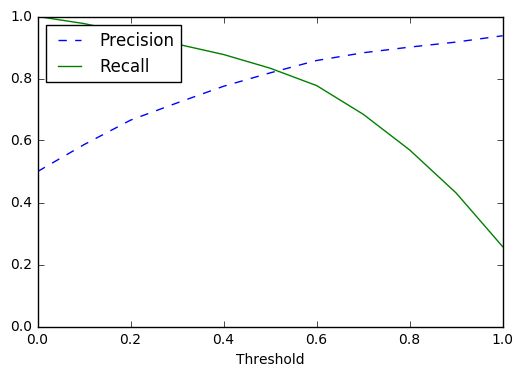

In [155]:
pred_proba = cross_val_predict (rf_clf, college, college_label, cv=3, method='predict_proba') [:,1]
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(college_label,pred_proba)
plot_precision_recall_vs_threshold(precisions_rf, recalls_rf, thresholds_rf)

### 3.3 The ROC curve

In [139]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(college_label, pred_proba) 

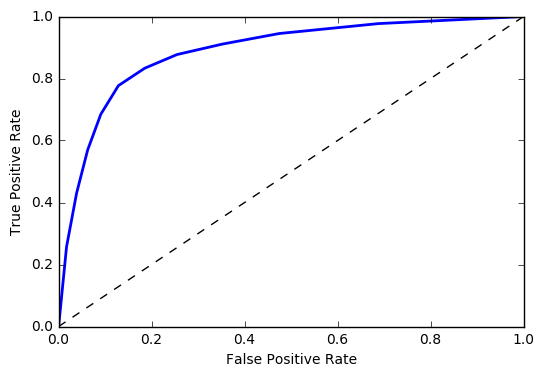

In [140]:
plot_roc_curve(fpr_rf, tpr_rf, "Random Forest")
plt.show()

## 4. SVM Classifier

### 4.1 Train a SVM model

In [141]:
svm_clf = sk_pl.Pipeline((
                ("scaler", sk_pp.StandardScaler()),
                ("svm_clf", sk_sv.SVC(kernel="poly", degree=1, coef0=1, C=5, random_state=123))
                ))

svm_clf.fit(college, college_label)

Pipeline(steps=(('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape=None, degree=1, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False))))

### 4.2 Measuring the performance on training set

In [142]:
pred = svm_clf.predict(college)
svm_clf.score(college,college_label )

0.84480965258997298

In [134]:
print(classification_report(college_label, pred))

             precision    recall  f1-score   support

          0       0.82      0.89      0.85      2403
          1       0.88      0.80      0.84      2404

avg / total       0.85      0.84      0.84      4807



### 4.3 Measuring the performance using cross-validation

In [135]:
# 3 fold cross‐validation
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
for train_index, test_index in skfolds.split(college,college_label):
    clone_clf = clone(svm_clf)
    X_train_folds = college[train_index]
    y_train_folds = (np.array(college_label)[train_index])
    X_test_fold = college[test_index]
    y_test_fold = np.array(college_label)[test_index]
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.781035558328
0.830212234707
0.701622971286


In [143]:
pred_svm = cross_val_predict(svm_clf, college, college_label, cv=3)
print(classification_report(college_label, pred_svm))

             precision    recall  f1-score   support

          0       0.74      0.84      0.79      2403
          1       0.82      0.70      0.75      2404

avg / total       0.78      0.77      0.77      4807



### 4.4 ROC curve

In [146]:
df_svm = cross_val_predict(svm_clf, college, college_label, cv=3, method="decision_function")
fpr_svm, tpr_svm, thresholds_svm = roc_curve(college_label, df_svm)

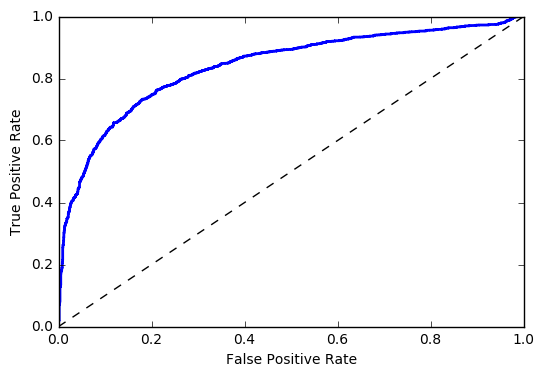

In [147]:
plot_roc_curve(fpr_svm, tpr_svm, "SVM")
plt.show()

## 5. Model Comparison

In [157]:
print("Logistic", classification_report(college_label, y_train_pred))
print("Random Forest", classification_report(college_label, pred_rf))
print("SVM", classification_report(college_label, pred_svm))

Logistic              precision    recall  f1-score   support

          0       0.76      0.84      0.80      2403
          1       0.82      0.73      0.77      2404

avg / total       0.79      0.79      0.79      4807

Random Forest              precision    recall  f1-score   support

          0       0.80      0.87      0.83      2403
          1       0.86      0.78      0.82      2404

avg / total       0.83      0.82      0.82      4807

SVM              precision    recall  f1-score   support

          0       0.74      0.84      0.79      2403
          1       0.82      0.70      0.75      2404

avg / total       0.78      0.77      0.77      4807



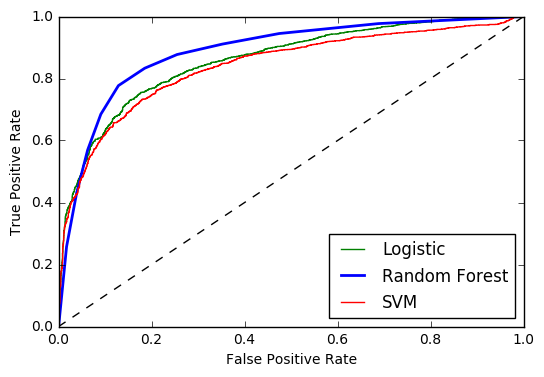

In [170]:
plt.plot(fpr,tpr,"g-", label='Logistic')
plot_roc_curve(fpr_rf, tpr_rf, 'Random Forest')
plt.plot(fpr_svm, tpr_svm, "r-", label='SVM')
plt.legend(loc='lower right')
plt.show()

In [149]:
print("Logistic Regression:", roc_auc_score(college_label,y_scores[:,1]))
print("Random Forest:",roc_auc_score(college_label, pred_proba))
print("SVM:",roc_auc_score(college_label, df_svm))

Logistic Regression: 0.858971868913
Random Forest: 0.886257506736
SVM: 0.839746212963


By checking the classification report, ROC curve, and the auc socre, we find out that random forest model is the best for this data set.Therefore, we will fine-tune the random forest model to find out our final model.

## 6. Fine-tune the model

In [172]:
from sklearn.model_selection import GridSearchCV
np.random.seed(123) 
# define which hyperparameters and corresponding values we want to experiment
param_grid = [
    {'n_estimators': [30, 50, 70], 'max_features': [20, 30, 40, 50],"min_samples_leaf":[5, 10, 20]},
    {'bootstrap': [False], 'n_estimators': [30, 50, 70], 'max_features': [20, 30, 40, 50],"min_samples_leaf":[5, 10, 20]},
  ] 

rf_class = RandomForestClassifier(random_state = 42)

# search the best combination using 3-fold cross-validation
np.random.seed(123) 
grid_search = GridSearchCV(rf_class, param_grid, cv=3,
                           scoring='neg_mean_squared_error') 

grid_search.fit(college, college_label)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [30, 50, 70], 'min_samples_leaf': [5, 10, 20], 'max_features': [20, 30, 40, 50]}, {'n_estimators': [30, 50, 70], 'min_samples_leaf': [5, 10, 20], 'bootstrap': [False], 'max_features': [20, 30, 40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [173]:
grid_search.best_params_

{'max_features': 40, 'min_samples_leaf': 5, 'n_estimators': 50}

Try retain only 40 features and use 'n_estimators'= 50 to build the final model.

In [198]:
rf_clf = RandomForestClassifier(random_state = 42, n_estimators = 50, min_samples_leaf = 5, max_features = 40)
rf_clf.fit(college, college_label)；

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=40, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [199]:
pred = cross_val_predict(rf_clf, college, college_label, cv=3)
print(confusion_matrix(college_label, pred))

[[2109  294]
 [ 438 1966]]


In [200]:
print(classification_report(college_label, pred)) 

             precision    recall  f1-score   support

          0       0.83      0.88      0.85      2403
          1       0.87      0.82      0.84      2404

avg / total       0.85      0.85      0.85      4807



## 6. Evaluate on test data

In [201]:
test_pred = rf_clf.predict(college_test)

In [202]:
print(confusion_matrix(college_test_label,test_pred))

[[559  53]
 [ 69 562]]


In [203]:
print(classification_report(college_test_label,test_pred)) 

             precision    recall  f1-score   support

          0       0.89      0.91      0.90       612
          1       0.91      0.89      0.90       631

avg / total       0.90      0.90      0.90      1243

